# Kitesurfer Detection with Roboflow

I created a dataset of images from Google of beaches with kitesurfers and labeled and trained a model from a public checkpoint of YOLO-NAS Object Detection using Roboflow.

As a kitesurfer myself, my motivation for this project comes from the need to count the number of kitesurfers in a live beach feed and provide a more detailed description of the kitesurfing conditions (number of people on the water).

Many public beaches currently have live feeds including [this example feed](https://www.youtube.com/watch?v=fOwd-xu3P_Y
) and [this example feed](https://www.iplivecams.com/live-cams/miami-kiteboarding-key-biscayne-florida-united-states/) which are used in this notebook.

In [ ]:
!pip install inference_sdk
!pip install roboflow
!pip install ultralytics
!pip install python-dotenv

In [2]:
import cv2
import matplotlib.pyplot as plt
from inference_sdk import InferenceHTTPClient
import numpy as np
import supervision as sv

from IPython.display import Video
from dotenv import load_dotenv
import os

load_dotenv()

True

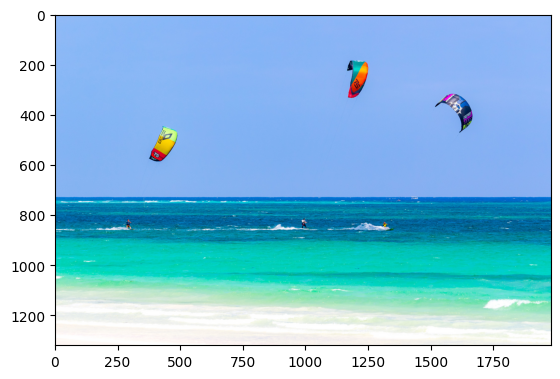

In [3]:
image = cv2.imread("images/IMG_4451.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

## Data Gathering and Labeling


I used a Chrome Extension to download images of kitesurfers in the water. Using Roboflow's data labeling tool, all the images were initially labeled using a foundational model. From there, I was able to correct the labels and add them to a dataset.


![Roboflow Labeling](./images/roboflow_labeling.png)

## Model Training

I used Roboflow to fine-tune a YOLO-NAS Object Detection model on the dataset from the `coco-14` checkpoint.

70% of the data was used for training 20% for testing and 10% for validation. Additionally, I specified to create additional training data by applying rotational and contrast augmentations to the dataset.

![Data Augmentation](./images/rotated_training_img.png)

After training the model, it had a mAP of 86.9% on the validation set with a recall of 74% and a recall of 90.6%.

![Training Graphs](./images/training_graphs.png)

## Model Deployment

Using Roboflow's model deployment, I was able to use the provided endpoint for inference.



In [4]:
def label_predictions(frame: np.ndarray, predictions) -> np.ndarray:
    labeled_image = frame.copy()

    for bounding_box in predictions:
        x0 = bounding_box['x'] - bounding_box['width'] / 2
        x1 = bounding_box['x'] + bounding_box['width'] / 2
        y0 = bounding_box['y'] - bounding_box['height'] / 2
        y1 = bounding_box['y'] + bounding_box['height'] / 2

        start_point = (int(x0), int(y0))
        end_point = (int(x1), int(y1))
        cv2.rectangle(labeled_image, start_point, end_point, color=(0, 0, 0), thickness=1)

        cv2.putText(
            labeled_image,
            bounding_box["class"],
            (int(x0), int(y0) - 10),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.6,
            color=(255, 255, 255),
            thickness=2
        )

    return labeled_image

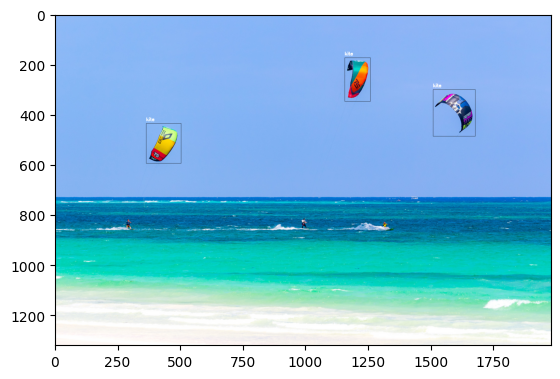

Number of kitesurfers:  3


In [5]:
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key=os.environ['ROBOFLOW_API_KEY'],
)

image = cv2.imread("images/IMG_4451.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

result = CLIENT.infer(image, model_id="kitesurfer-detection/1")

labeled = label_predictions(image, result['predictions'])

plt.imshow(labeled)
plt.show()

print("Number of kitesurfers: ", len(result['predictions']))

## Video Inference

We can similarly label kitesurfers in a video by labeling each frame individually. This video feed was taken from a live beach cam found at this [link](https://www.youtube.com/watch?v=fOwd-xu3P_Y). The video quality is particularly bad in this video and we see the kite lags between frames.

In [ ]:
Video("./images/beach_cam.mp4", html_attributes="loop autoplay", height=500)

![beach_cam](https://github.com/mschettewi/Kitesurfer-Detection/assets/25996096/a0e45b92-c887-48d2-9e18-08282394f321)

In [19]:
number_of_kites = []


def process_frame(frame: np.ndarray, _) -> np.ndarray:
    results = CLIENT.infer(frame, model_id="kitesurfer-detection/1")
    num_kites_in_frame = len(results['predictions'])
    number_of_kites.append(num_kites_in_frame)
    return label_predictions(frame, results['predictions'])


sv.process_video(source_path="./images/beach_cam.mp4", target_path="./images/result.mp4", callback=process_frame)

print("Average number of kitesurfers in the video: ", np.mean(number_of_kites))

Average number of kitesurfers in the video:  7.849902534113061


The kitesurfers are labeled in the resulting video below. The video quality is bad on the original feed, meanwhile, our model was trained primarily on high-quality Google images. In the video classifier, the date on the top right of the screen is classified as a kite, and some wingfoilers are classified as kitesurfers (they do look very similar).

In [ ]:
Video("./images/result.mp4", html_attributes="loop autoplay", height=500)

![result](https://github.com/mschettewi/Kitesurfer-Detection/assets/25996096/81c7ac13-4317-4b0e-b88f-1040c8d811e4)

## Key Biscayne Live Stream

This video stream features more kites and is sourced from the [Key Biscayne Live Stream](https://www.iplivecams.com/live-cams/miami-kiteboarding-key-biscayne-florida-united-states/).


In [ ]:
Video("./images/KeyBiscayneLiveCam.mp4", html_attributes="loop autoplay", height=500)

![KeyBiscayneLiveCam](https://github.com/mschettewi/Kitesurfer-Detection/assets/25996096/dbead374-c5d7-4f18-8ab5-9d9f23da14fb)

In [16]:
number_of_kites = []


def process_frame(frame: np.ndarray, _) -> np.ndarray:
    results = CLIENT.infer(frame, model_id="kitesurfer-detection/1")
    num_kites_in_frame = len(results['predictions'])
    number_of_kites.append(num_kites_in_frame)
    return label_predictions(frame, results['predictions'])


sv.process_video(source_path="./images/KeyBiscayneLiveCam.mp4", target_path="./images/KeyBiscayneLiveCamResults.mp4", callback=process_frame)

print("Average number of kitesurfers in the video: ", np.mean(number_of_kites))

Average number of kitesurfers in the video:  12.445714285714285


It is an important distinction that in our dataset, we only labeled kites that are in the air because it's not important how many kites are on the beach when we are evaluating if it is crowded. Although we have a few false positives around the wind meter and a cone, it does not misclassify the kites on the beach as kitesurfers. In this video, we do a pretty good job of identifying kitesurfers, although the far-away kitesurfers on the right side of the horizon are not correctly classified. This could be due to a lack of variety in our dataset.


In [ ]:
Video("./images/KeyBiscayneLiveCamResults.mp4", html_attributes="loop autoplay", height=500)

![KeyBiscayneLiveCamResults](https://github.com/mschettewi/Kitesurfer-Detection/assets/25996096/72cff3bb-5217-41ab-8cab-7b85269da24f)

Overall, this is a good starting point to count the number of kitesurfers on the water. A current limitation is the lack of data that the model was fine-tuned on (only about 600 objects over 100 images). A further enhancement could be to add more classification classes, eg. windsurfers, wingfoilers, surfers, etc. Additionally, I could integrate the model inference into a live feed for real-time predictions.